## Notebook presentation

This notebook was made to show how you can use a regression model to predict a target by using just a few preprocessing steps and still get high performance. The quality control is always useful using graphs from matplotlib and seaborn libraries, as well as descriptive analytics functions from pandas. 

## Data description

This notebook uses data from Volve field from Equinor that made the dataset public in 2018. This is part of it and we will only look at 5 wells while trying to predict sonic log info in two of these wells.

The LAS files show info for 24 features but below you can see a description for the main ones:

1. DEPTH (below surface)
2. NPHI (neutron porosity)
3. RHOB (bulk density)
4. GR (gamma ray)
5. RT (true resistivity)
6. PEF (photoelectric factor)
7. CALI (caliper - borehole diameter)
8. DT (sonic log)


In [1]:
import os
import lasio
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
# Data path
rootdir = "C:/Users/lucas.aguiar/Desktop/Pastas/Estudos/Portfolio/VOLVE_WELL_LOGS/"

In [3]:
# Data import
data_dict = {}
for filename in os.listdir(rootdir):
    
    if filename.endswith(".LAS"):
        
        las = lasio.read(rootdir + filename)
        
        # Convert to dataframe
        df = las.df().reset_index()
        
        # Wellname
        wellname = filename[:-4]
        df["WELL"] = wellname
        
        data_dict[wellname] = df
        
data_dict.keys()       

dict_keys(['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C'])

In [4]:
# Data concatenation
data_concat = pd.concat(data_dict)

In [5]:
# Data first check
print("Data Size (rows, cols):", data_concat.shape)

data_concat.head(10)

Data Size (rows, cols): (189586, 24)


DEPTH  ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  \
15_9-F-11A 0  188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           1  188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           2  188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           3  188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           4  188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           5  189.0       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           6  189.1       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           7  189.2       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           8  189.3       NaN       NaN       NaN       NaN  36.0   NaN   NaN   
           9  189.4       NaN       NaN       NaN       NaN  36.0   NaN   NaN   

              DT  DTS  ...  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  \
15_9-F-11A 0 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           1 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           2 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           3 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           4 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           5 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           6 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           7 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           8 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   
           9 NaN  NaN  ...     NaN NaN   NaN NaN  NaN     NaN     NaN NaN   

                    WELL  NBGRCFM  
15_9-F-11A 0  15_9-F-11A      NaN  
           1  15_9-F-11A      NaN  
           2  15_9-F-11A      NaN  
           3  15_9-F-11A      NaN  
           4  15_9-F-11A      NaN  
           5  15_9-F-11A      NaN  
           6  15_9-F-11A      NaN  
           7  15_9-F-11A      NaN  
           8  15_9-F-11A      NaN  
           9  15_9-F-11A      NaN  

[10 rows x 24 columns]

In [6]:
# Column names
data_concat.columns

Index(['DEPTH', 'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI',
       'DRHO', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD',
       'RHOB', 'RM', 'ROP', 'RPCEHM', 'RPCELM', 'RT', 'WELL', 'NBGRCFM'],
      dtype='object')

DEPTH            0
ABDCQF01    137995
ABDCQF02    138130
ABDCQF03    138567
ABDCQF04    138136
BS               0
CALI        137873
DRHO        137964
DT          163625
DTS         164479
GR            2320
NPHI        138483
PEF         138348
RACEHM       85899
RACELM       85899
RD           39529
RHOB        138348
RM           39288
ROP           3289
RPCEHM       85951
RPCELM       86174
RT           28449
WELL             0
NBGRCFM     165810
dtype: int64


<Axes: >

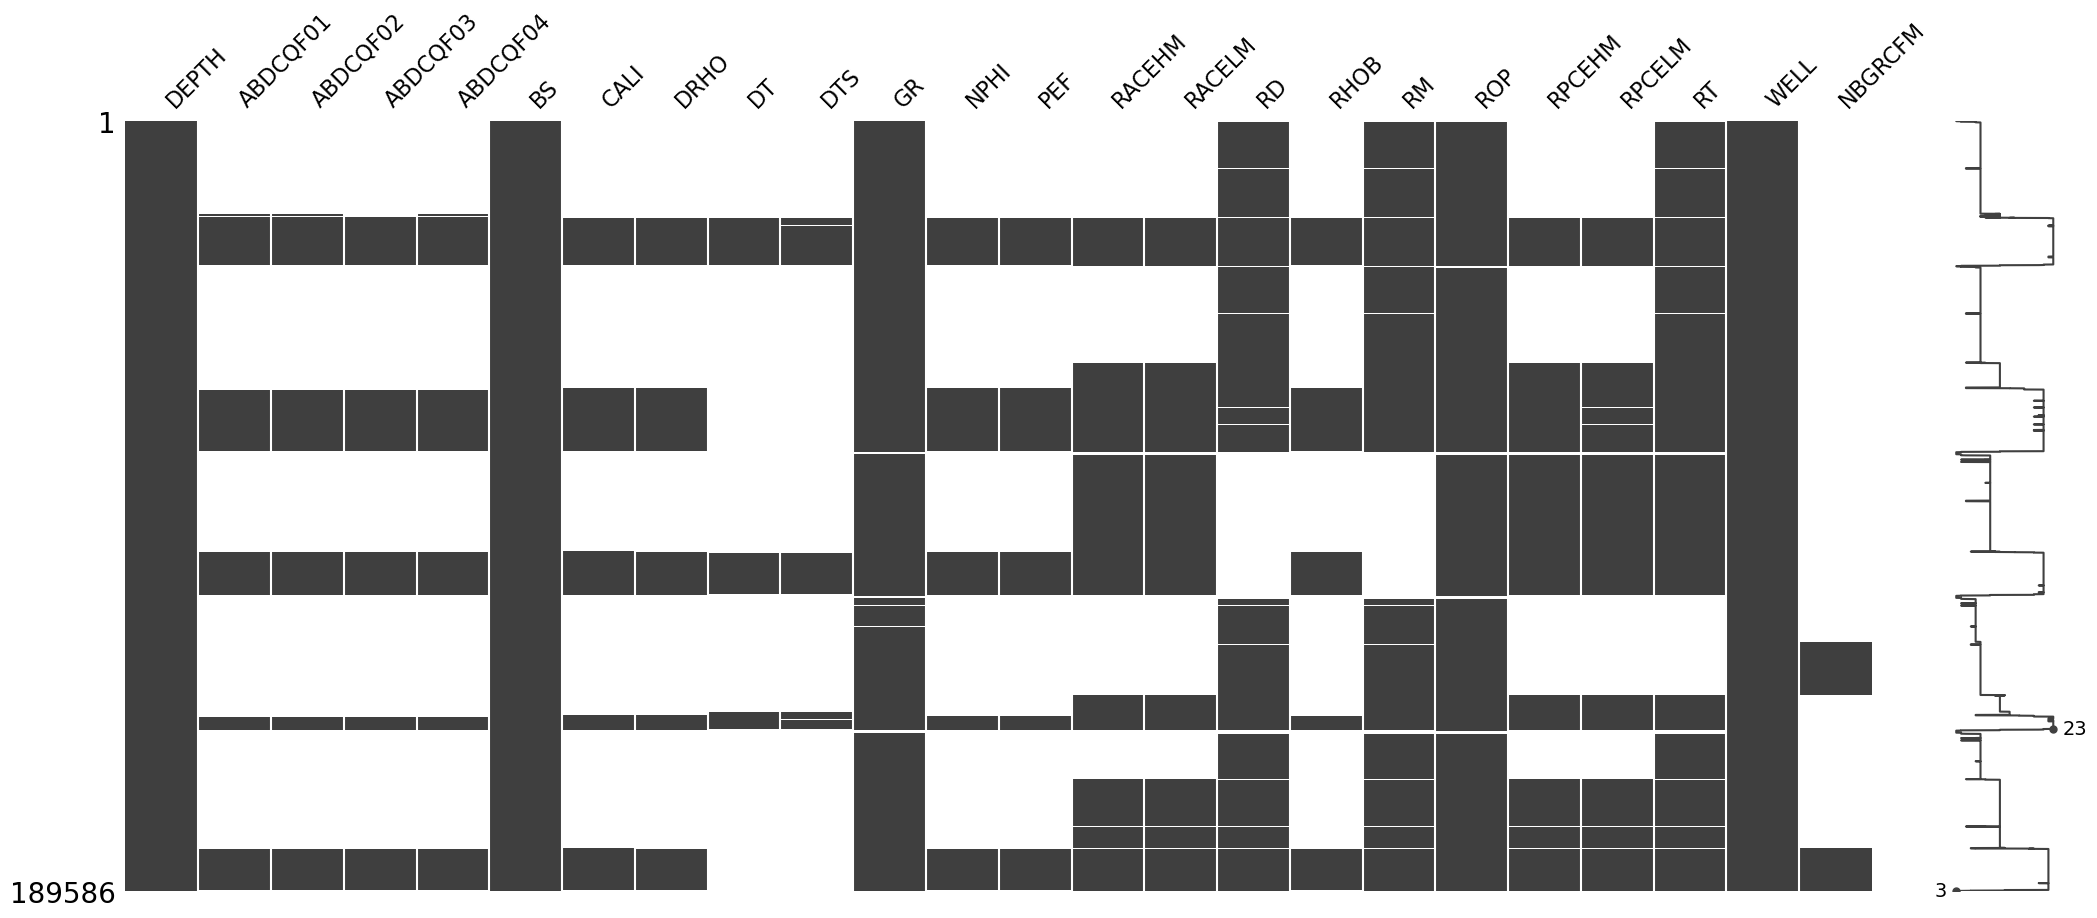

In [7]:
# Checking missing data
print(data_concat.isna().sum())

mno.matrix(data_concat)

In [8]:
# Dropping rows to select only data where feature RHOB is not NaN (important data)
reduced_data = data_concat.dropna(subset=["RHOB"], axis=0)
reduced_data.shape

(51238, 24)

In [9]:
reduced_data["WELL"].unique()

array(['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C'],
      dtype=object)

In [10]:
# Descriptive statistics
reduced_data.describe()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT,NBGRCFM
count,51238.000000,50677.000000,50677.000000,50677.000000,50679.000000,51238.0,51206.000000,51238.000000,24950.000000,24112.000000,...,51238.000000,51238.000000,40446.00000,51238.000000,40687.000000,51118.000000,51238.000000,50997.000000,51238.000000,10129.000000
mean,3486.873422,2.432446,2.432846,2.435376,2.430954,8.5,8.618367,0.051894,78.151115,142.740422,...,193.774666,54.704923,21.61871,2.430850,1077.215304,24.306828,860.928155,17.783327,857.292286,46.795395
std,498.748182,0.170198,0.165807,0.172492,0.165800,0.0,0.069548,0.018195,14.548494,35.142756,...,1024.433882,296.381223,174.71423,0.162629,7969.744573,6.906804,7128.398483,155.781959,7118.230687,41.191312
min,2577.000000,1.513000,0.885600,0.494000,1.594000,8.5,8.304900,-0.982500,53.165000,83.574000,...,0.093000,0.040000,0.08400,1.627000,0.065000,0.005100,0.064900,0.084000,0.065000,6.952600
25%,3154.600000,2.264900,2.269300,2.267300,2.267100,8.5,8.578000,0.044000,67.689000,121.526975,...,1.830100,1.781450,1.92800,2.269500,2.125000,19.774850,2.039000,1.858000,2.028000,26.991800
50%,3419.500000,2.475000,2.475000,2.478300,2.474000,8.5,8.625000,0.052000,73.880000,132.383800,...,3.009850,2.826000,3.41660,2.473100,4.066000,25.097000,3.624550,3.092900,3.616000,40.621300
75%,3768.200000,2.567200,2.571000,2.574000,2.568000,8.5,8.671900,0.060000,86.629475,147.026250,...,6.594750,5.717950,8.58925,2.567700,10.778950,29.912000,8.088000,6.908000,8.069000,55.324700
max,4747.300000,3.419200,3.221700,3.402000,3.607200,8.5,9.175000,0.201000,126.827000,343.944000,...,6381.099100,2189.603000,5571.43510,3.090000,62290.770000,44.343500,62290.770000,5571.435100,62290.770000,1042.129600


In [11]:
# Data types
reduced_data.dtypes

DEPTH       float64
ABDCQF01    float64
ABDCQF02    float64
ABDCQF03    float64
ABDCQF04    float64
BS          float64
CALI        float64
DRHO        float64
DT          float64
DTS         float64
GR          float64
NPHI        float64
PEF         float64
RACEHM      float64
RACELM      float64
RD          float64
RHOB        float64
RM          float64
ROP         float64
RPCEHM      float64
RPCELM      float64
RT          float64
WELL         object
NBGRCFM     float64
dtype: object

In [12]:
# Principal feature selection
reduced_data = reduced_data[['DEPTH', 'CALI', 'DRHO', 'DT', 'GR', 'NPHI', 'PEF', 'RHOB', 'RT', 'WELL']]

Text(0.5, 1.0, 'Pearson Correlation')

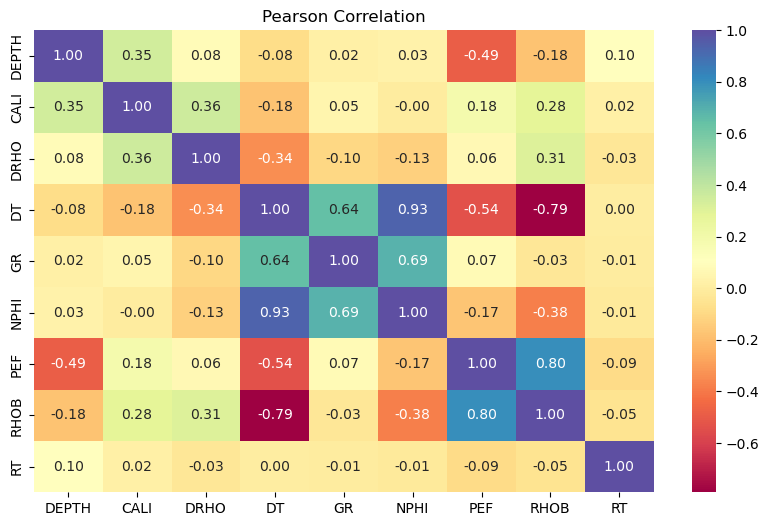

In [13]:
# Statistical correlation between well logs to find those that can be imported to predict DT
plt.figure(figsize=(10,6))
sns.heatmap(reduced_data.corr(numeric_only=True), cmap="Spectral", annot=True, fmt=".2f")
plt.title("Pearson Correlation")

In [14]:
# Wells
reduced_data["WELL"].unique()

array(['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C'],
      dtype=object)

In [15]:
# Check for empty DTC values in each well
for well in reduced_data["WELL"].unique():
    
    temp = reduced_data.loc[reduced_data["WELL"] == well]
    
    print(well, temp.shape, temp["DT"].isna().sum())

15_9-F-11A (11625, 10) 161
15_9-F-11B (15492, 10) 15492
15_9-F-1A (10551, 10) 327
15_9-F-1B (3441, 10) 179
15_9-F-1C (10129, 10) 10129


In [16]:
# Selecting training, validation and blind data
training_data = reduced_data.loc[~reduced_data["WELL"].isin(["15_9-F-11B","15_9-F-1C","15_9-F-1B"])]
validation_data = reduced_data.loc[reduced_data["WELL"] == "15_9-F-1B"]
blind_data = reduced_data.loc[reduced_data["WELL"].isin(["15_9-F-11B","15_9-F-1C"])]

print("Training data shape:", training_data.shape)
print("Validation data shape:", validation_data.shape)
print("Blind data shape:", blind_data.shape)

Training data shape: (22176, 10)
Validation data shape: (3441, 10)
Blind data shape: (25621, 10)


In [17]:
# Dropping null values based on DT
training_data = training_data.dropna(subset=["DT"], axis=0)
training_data.isna().sum()

DEPTH    0
CALI     0
DRHO     0
DT       0
GR       0
NPHI     0
PEF      0
RHOB     0
RT       0
WELL     0
dtype: int64

In [18]:
# Columns to use in the model
features = ['PEF', 'NPHI', 'RHOB', 'GR', 'RT']

In [19]:
# Splitting data by 20% for testing
X_train, X_test, y_train, y_test = train_test_split(training_data[features], # X
                                                    training_data["DT"], # y
                                                    test_size=0.2,
                                                    random_state=0)

In [20]:
# Model
model = ExtraTreesRegressor(random_state=0)
model.fit(X_train, y_train)


ExtraTreesRegressor(random_state=0)

In [21]:
# Prediction on test data and performance evaluation
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.9664434709944565

In [22]:
# Cross validation
scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=4)
print("Scores:", scores, "Mean:", scores.mean())

Scores: [0.96282256 0.96774711 0.96713275 0.9633959 ] Mean: 0.9652745795858062


In [23]:
# Dropping null values based on selected features
validation_data = validation_data.dropna(subset=features, axis=0)
blind_data = blind_data.dropna(subset=features, axis=0)
blind_data.isna().sum()

DEPTH        0
CALI         0
DRHO         0
DT       25569
GR           0
NPHI         0
PEF          0
RHOB         0
RT           0
WELL         0
dtype: int64

In [24]:
# As the model got a high performance, now we will make the prediction to look at the validation well
validation_data = validation_data.dropna(subset=["DT"], axis=0)
validation_data["DT_PRED"] = model.predict(validation_data[features])

Text(0.5, 1.0, 'r²: 0.9065')

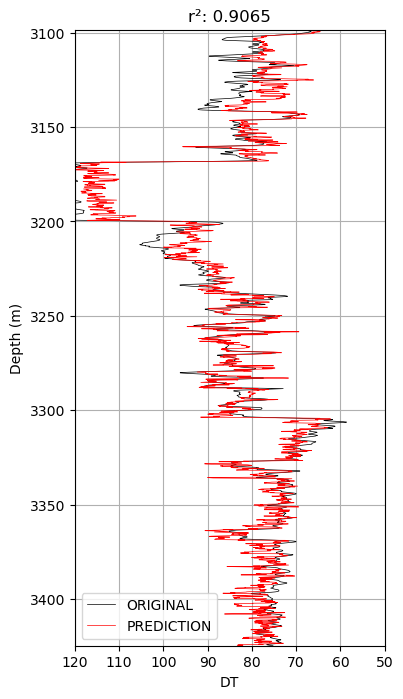

In [25]:
# Plot DT x DT_PRED
plt.figure(figsize=(4,8))
plt.plot(validation_data["DT"], validation_data["DEPTH"], color='black', linewidth=0.5, label="ORIGINAL")
plt.plot(validation_data["DT_PRED"], validation_data["DEPTH"], color='red', linewidth=0.5, label="PREDICTION")
plt.xlabel("DT")
plt.ylabel("Depth (m)")
plt.xlim(120, 50)
plt.ylim(validation_data["DEPTH"].max(), validation_data["DEPTH"].min())
plt.grid()
plt.legend()
plt.title("r²: {:.4f}". format(r2_score(validation_data["DT"], validation_data["DT_PRED"])))

C:\Users\lucas.aguiar\AppData\Local\Temp\ipykernel_19448\2574626809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_df["DT_PRED"] = model.predict(well_df[features])
C:\Users\lucas.aguiar\AppData\Local\Temp\ipykernel_19448\2574626809.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1) # GR
C:\Users\lucas.aguiar\AppData\Local\Temp\ipykernel_19448\2574626809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<Figure size 640x480 with 0 Axes>

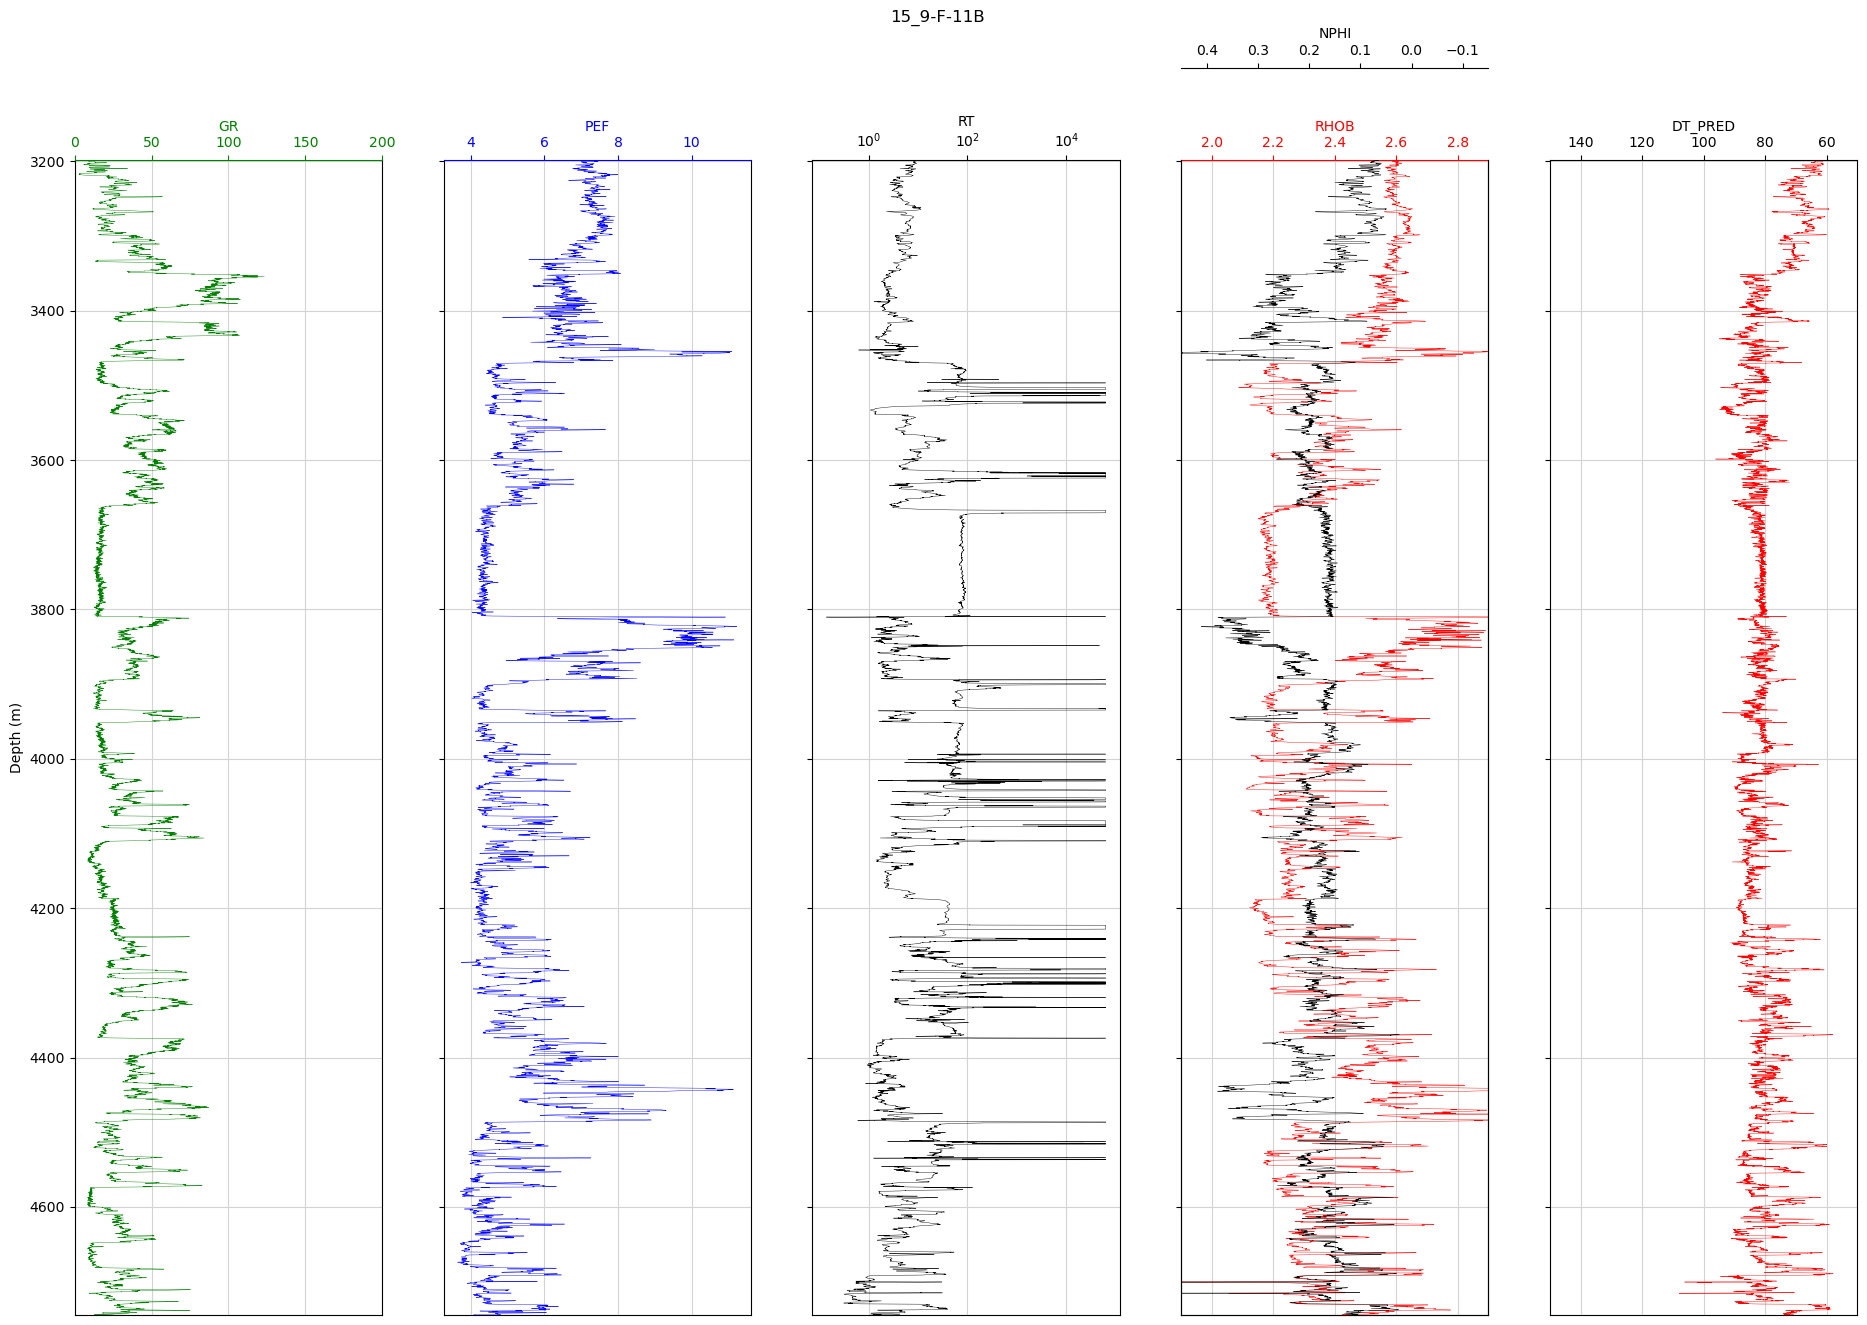

<Figure size 640x480 with 0 Axes>

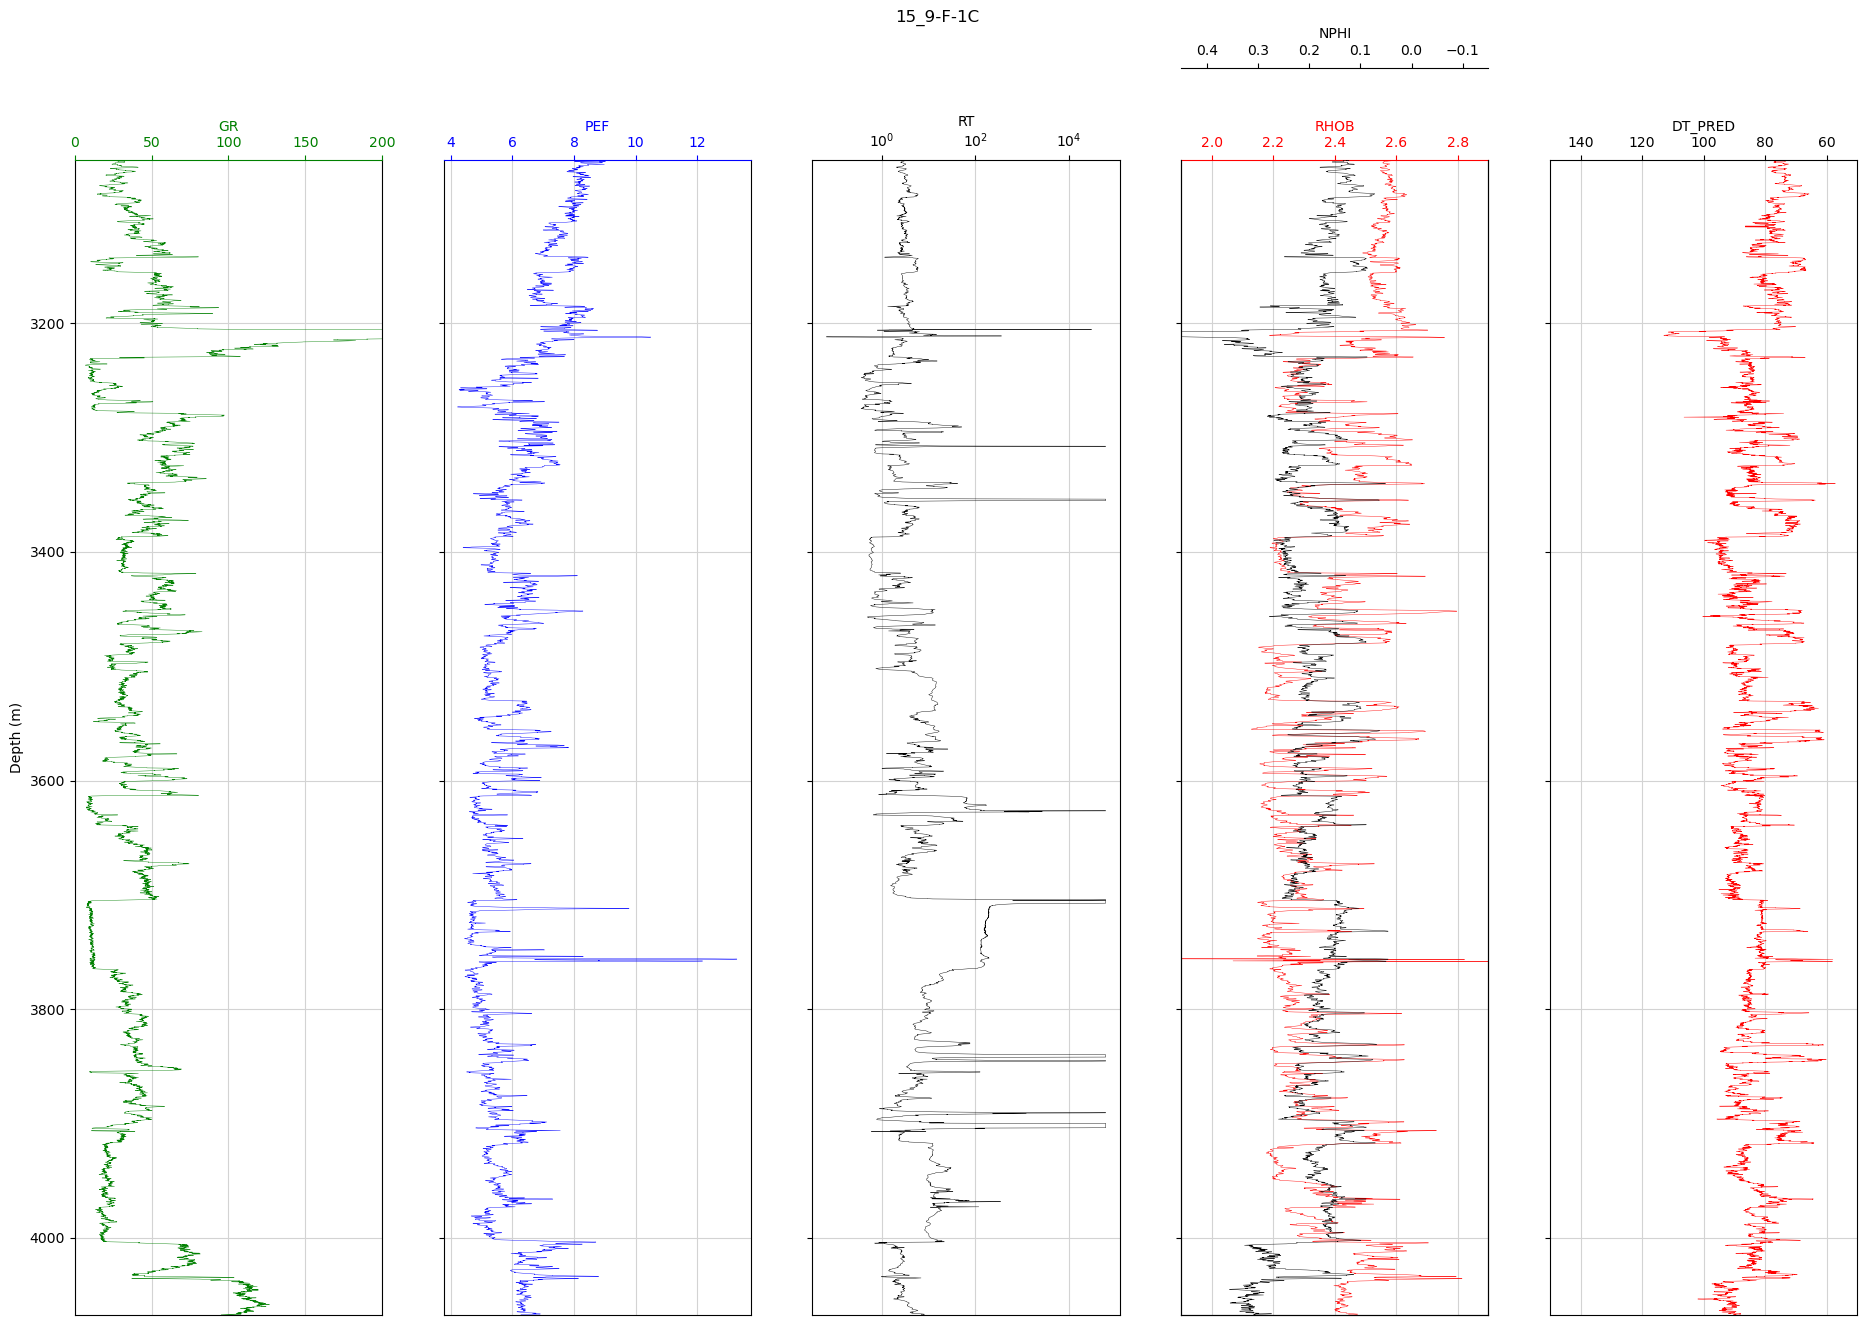

In [26]:
# Prediction on the blind data
for well in blind_data["WELL"].unique():
    
    # Well selection
    well_df = blind_data.loc[blind_data["WELL"] == well]
    well_df["DT_PRED"] = model.predict(well_df[features])
    
    depth = well_df["DEPTH"]
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(23,15))

    zbot = depth.max()
    ztop = depth.min()

    # Set up the plot axes
    ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1) # GR
    ax2 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan = 1, sharey = ax1) # PEF
    ax3 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan = 1, sharey = ax1) # RT
    ax4 = plt.subplot2grid((1,5), (0,3), rowspan=1, colspan = 1, sharey = ax1) # RHOB
    ax5 = plt.subplot2grid((1,5), (0,4), rowspan=1, colspan = 1, sharey = ax1) # DT PRED

    ax6 = ax4.twiny() # twin RHOB X NPHI

    # GR
    ax1.plot(well_df["GR"], depth, color="green", linewidth=0.3)
    ax1.set_xlabel("GR")
    ax1.xaxis.label.set_color("green")
    ax1.set_ylabel("Depth (m)")
    ax1.set_xlim(0, 200)
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')

    # PEF
    ax2.plot(well_df["PEF"], depth, color='blue', linewidth=0.3)
    ax2.set_xlabel("PEF")
    ax2.xaxis.label.set_color("blue")
    ax2.tick_params(axis='x', colors="blue")
    ax2.spines["top"].set_edgecolor("blue")

    # RT
    ax3.plot(well_df["RT"], depth, color='black', linewidth=0.3)
    ax3.set_xlabel("RT")
    ax3.set_xscale('log')
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")

    # RHOB
    ax4.plot(well_df["RHOB"], depth, color="red", linewidth=0.3)
    ax4.set_xlabel("RHOB")
    ax4.set_xlim(1.9, 2.9)
    ax4.xaxis.label.set_color("red")
    ax4.tick_params(axis='x', colors="red")
    ax4.spines["top"].set_edgecolor("red")

    # DT
    ax5.plot(well_df["DT_PRED"], depth, color='red', linewidth=0.3)
    ax5.set_xlabel("DT_PRED")
    ax5.set_xlim(150, 50)
    ax5.xaxis.label.set_color("black")
    ax5.tick_params(axis='x', colors="black")
    ax5.spines["top"].set_edgecolor("black")

    # Neutron track placed ontop of density track
    ax6.plot(well_df["NPHI"], depth, color="black", linewidth=0.3)
    ax6.set_xlabel('NPHI')
    ax6.xaxis.label.set_color("black")
    ax6.set_xlim(0.45, -0.15)
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_position(("axes", 1.08))
    ax6.spines["top"].set_visible(True)
    ax6.spines["top"].set_edgecolor("black")

    # Common functions for setting up the plot can be extracted into a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_ylim(zbot, ztop)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.00))

    for ax in [ax2, ax3, ax4, ax5]:
        plt.setp(ax.get_yticklabels(), visible = False)      

    fig.suptitle(well) 

## Comments

This is just an example and, besides the model got high performance, it could get better by tuning the hyperparameters by find optimal values of max_depth and n_estimators, for example. Other applications during preprocessing steps could also improve the results with feature engineering (e.g. features generation through polynomial transformation) and anomalous value removal.